# Setup

## Fix import paths

The notebook lives in `<project_root>/notebooks/`, but imports should be relative to the project root.

In [1]:
# Fix up paths so we can import normally
import sys
import os
sys.path.insert(0, os.path.realpath('..'))

## Normal imports

In [2]:
import torch
import torchopt
from utils import dotdict
from autoencoders.sae_ensemble import FunctionalSAE
from autoencoders.sae import SAE
import numpy as np
from collections import deque
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

## Provide a path where the activations live

In [3]:
activation_files = [
    f'/workspace/sparse_coding/activation_data/sweep2/{i}.pt'
    for i in range(8)
]

## Set up config based on the activations in the first such file

In [4]:
cfg = dotdict({})

activations = torch.load(activation_files[0]).to(torch.float32).cuda()
cfg.activation_width = activations.shape[1]
cfg.dict_multiplier  = 4
cfg.l1_alpha         = 0.003;
cfg.bias_l2_coef     = 0.0;
cfg.dtype            = activations.dtype
cfg.device           = activations.device
cfg.batch_size       = 4096
cfg.lr               = 0.0003
cfg.test_frac        = 0.0001
cfg.run_name         = datetime.utcnow().strftime('%Y-%m-%d-%H-%M-%SZ')

print(f'activation_width = {cfg.activation_width}')
print(f'dict_multiplier = {cfg.dict_multiplier}')
print(f'l1_alpha = {cfg.l1_alpha}')
print(f'dtype = {cfg.dtype}')
print(f'device = {cfg.device}')
print(f'batch_size = {cfg.batch_size}')

del activations

activation_width = 512
dict_multiplier = 4
l1_alpha = 0.003
dtype = torch.float32
device = cuda:0
batch_size = 4096


# Training the models

## Define the model

In [5]:
models = [
    SAE(
        cfg.activation_width,
        n_dict_components=cfg.activation_width*cfg.dict_multiplier,
        l1_coef=cfg.l1_alpha,
        bias_l2_coef=cfg.bias_l2_coef,
        activation="relu",
        t_type=cfg.dtype,
        bias=True
    ).to(cfg.device),
    SAE(
        cfg.activation_width,
        n_dict_components=cfg.activation_width*cfg.dict_multiplier*2,
        l1_coef=cfg.l1_alpha,
        bias_l2_coef=cfg.bias_l2_coef,
        activation="relu",
        t_type=cfg.dtype,
        bias=True
    ).to(cfg.device),
]
optimizers = [
    torch.optim.Adam(models[0].parameters(), lr=cfg.lr),
    torch.optim.Adam(models[1].parameters(), lr=cfg.lr),
]

## Split activations into test/train

We want to make sure that we use the same test/train split during every epoch

In [6]:
splits = []
test_dataset_parts = []
n_train = 0
for file_idx, activation_file in enumerate(activation_files):
    activations = torch.load(activation_file).to(torch.float32).cuda()
    # For each file index, store which sample indexes correspond to test vs train
    file_idx_col = torch.ones((len(activations), 1)) * file_idx
    act_idx_col  = torch.arange(len(activations)).reshape(len(activations),1)
    is_train_col = torch.rand((len(activations), 1)) >= cfg.test_frac
    splits.append(torch.hstack([
        file_idx_col.to(int),
        act_idx_col.to(int),
        is_train_col.to(int)
    ]))
    test_dataset_parts.append(activations[is_train_col[:,0] == False])
    n_train += len(activations[is_train_col[:,0]])
splits = torch.vstack(splits)
test_dataset = torch.vstack(test_dataset_parts)

## Actually do the training run

In [7]:
losses = {'loss': [], 'recon': [], 'l1': []}
it = 0
next_loss_calc = 100
n_epochs = 10
train_idx = 0
max_its = 10000


with tqdm(total=min(max_its, (n_train * n_epochs) // cfg.batch_size)) as progress_bar:
    for epoch in range(n_epochs):
        for file_idx, activation_file in enumerate(activation_files):
            activations = torch.load(activation_file).to(torch.float32).cuda()
            train_act_idxs = splits[(splits[:,0] == file_idx)&(splits[:,2] == 1)][:,1]
            train_activations = activations[train_act_idxs]
            train_dataset = DataLoader(train_activations, batch_size=cfg.batch_size, shuffle=True)
            for _, train_batch in enumerate(train_dataset):
                for model, optimizer in zip(models, optimizers):
                    model.train_batch(train_batch, optimizer)
                    losses_at_step = {'loss':[], 'recon': [], 'l1': []}
                    if it >= next_loss_calc:
                        for _, test_batch in enumerate(test_dataset):
                            x_hat, c = model.forward(test_batch)
                            loss, l_reconstruction, l_l1 = model.loss(test_batch, x_hat, c)
                            losses_at_step['loss'].append(loss.detach().tolist())
                            losses_at_step['recon'].append(l_reconstruction.detach().tolist())
                            losses_at_step['l1'].append(l_l1.detach().tolist())
                        losses['loss'].append((it, sum(losses_at_step['loss']) / len(losses_at_step['loss'])))
                        losses['recon'].append((it, sum(losses_at_step['recon']) / len(losses_at_step['recon'])))
                        losses['l1'].append((it, sum(losses_at_step['l1']) / len(losses_at_step['l1'])))
                        next_loss_calc = int((next_loss_calc + 1) * 1.2)
                it += 1
                progress_bar.update(1)
                if it >= max_its: break
            if it >= max_its: break
        if it >= max_its: break

losses['loss'] = np.array(losses['loss'])
losses['recon'] = np.array(losses['recon'])
losses['l1'] = np.array(losses['l1'])

100%|██████████| 10000/10000 [03:37<00:00, 46.08it/s]


# Verify the results look sane

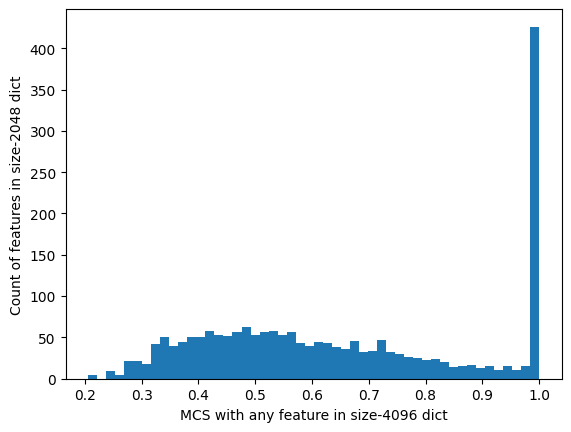

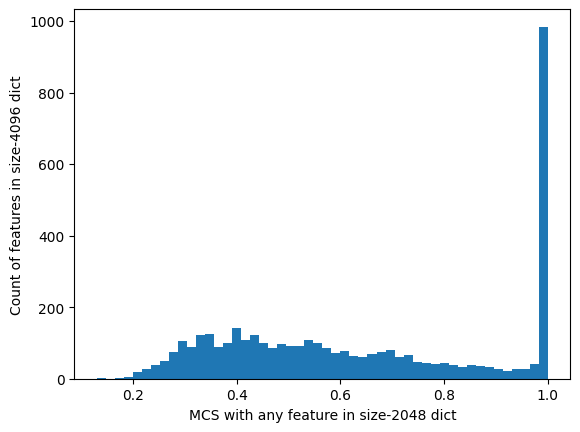

In [8]:
d0 = models[0].decoder.weight.clone().detach()
d1 = models[1].decoder.weight.clone().detach()

d0 /= torch.linalg.norm(d0, axis=0)
d1 /= torch.linalg.norm(d1, axis=0)

plt.xlabel(f"MCS with any feature in size-{d1.shape[1]} dict")
plt.ylabel(f"Count of features in size-{d0.shape[1]} dict")
plt.hist((d0.T @ d1).amax(axis=1).cpu(), bins=50)
plt.show()

plt.xlabel(f"MCS with any feature in size-{d0.shape[1]} dict")
plt.ylabel(f"Count of features in size-{d1.shape[1]} dict")
plt.hist((d1.T @ d0).amax(axis=1).cpu(), bins=50)
plt.show()

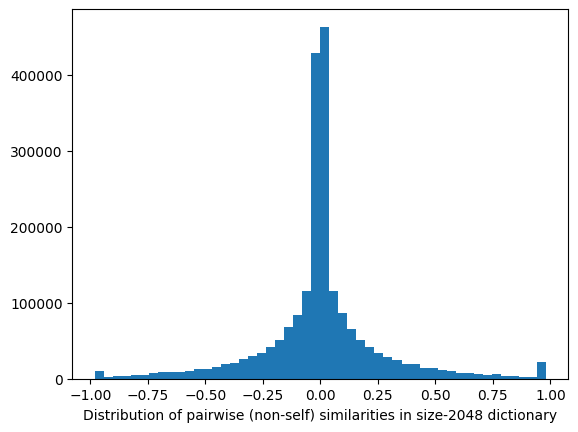

In [15]:
self_cosine_sim = (d0.T @ d0)

# Verify that dot product is in fact cosine sim here
assert 0.999 < self_cosine_sim.diag().min() < 1.001
assert 0.999 < self_cosine_sim.diag().max() < 1.001

# Plot the pairwise self-sim
pairwise_self_similarities = self_cosine_sim[np.triu_indices(d0.shape[1], k=1)].cpu()
hist = torch.histogram(pairwise_self_similarities, bins = 50, range=(-1.0, +1.0))
plt.xlabel(f"Distribution of pairwise (non-self) similarities in size-{d0.shape[1]} dictionary")
plt.hist((hist.bin_edges[:-1] + hist.bin_edges[1:]) / 2, hist.hist.shape[0], weights=hist.hist)
plt.show()

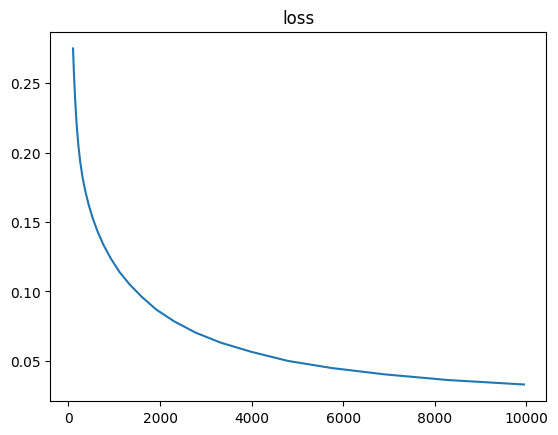

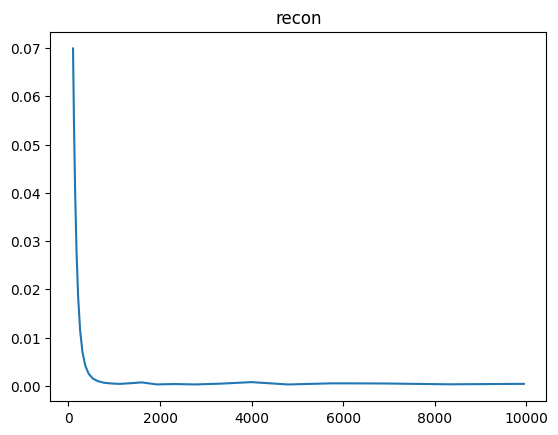

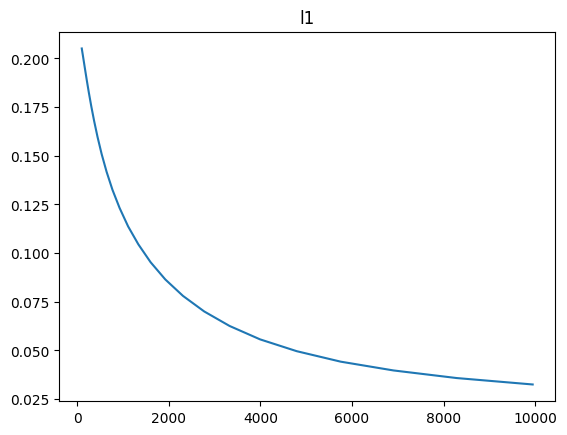

In [10]:
for k, loss in losses.items():
    plt.title(k)
    plt.plot(loss[:,0], loss[:,1])
    plt.show()

In [11]:
torch.save(models[0], f'/workspace/sparse_coding/outputs/manual.{cfg.run_name}.2048.pth')
torch.save(models[1], f'/workspace/sparse_coding/outputs/manual.{cfg.run_name}.4096.pth')